# Interpretive deep learning for investigating flooding mechanism

This simple example will demonstrate how to use the expected gradients and additive decomposition methods to interpret the LSTM-based hydrological model. The main procedure includes data preparation, model training, predictive performance evaluation, and applying the interpretation methods to analyze the trained model.

For running this notebook, no GPU is required, and everything should run fine on a standard CPU.

Date: 10.09.2021

Created by: Shijie Jiang (jiangsj(at)mail.sustech.edu.cn)

In [1]:
## Import libraries developed in this study
import libs.hydrodeepx_data as xdata
import libs.hydrodeepx_utils as xutils
import libs.hydrodeepx_interpret as xinterpret
import libs.hydrodeepx_plot as xplot

## Import dependent libraries
import os, logging, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from tqdm.keras import TqdmCallback

## Ignore all the warnings
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['KMP_WARNINGS'] = '0'

plt.rcParams.update(plt.rcParamsDefault)

Using TensorFlow backend.


In [2]:
WORKING_PATH  = os.getcwd()

####################
#   Basin set up   #
####################
STATION_ID    = '02329000' # USGS code used in the MOPEX dataset

####################
#  Hyperparameters #
####################
RANDOM_SEED   = 100        
WRAP_LENGTH   = 180        # Timestep of the LSTM model
TRAIN_FRAC    = 0.7        # The fraction of spliting traning and testing dataset

LEARNING_RATE = 0.03
EPOCH_NUMBER  = 100

In [3]:
mopex_path = os.path.join(WORKING_PATH, 'mopex', f'{STATION_ID}.dly')
data_path  = os.path.join(WORKING_PATH, 'data', f'{STATION_ID}_data.pickle')
model_path = os.path.join(WORKING_PATH, 'results', 'model', f'{STATION_ID}_{RANDOM_SEED}_keras.h5')
eg_path    = os.path.join(WORKING_PATH, 'results', 'eg',    f'{STATION_ID}_{RANDOM_SEED}_eg.pickle')

## 1. Prepare data

First, we load the downloaded MOPEX dataset for the station. The data to be used has 3 dims, including 2 inputs and 1 output:
- daily precipitation (`prcp`)
- daily mean temperature (`tmean`)
- daily streamflow (`flow`)

In [4]:
hydrodata   = xdata.get_station_data(fname=mopex_path)

### Plot the data loaded for overview

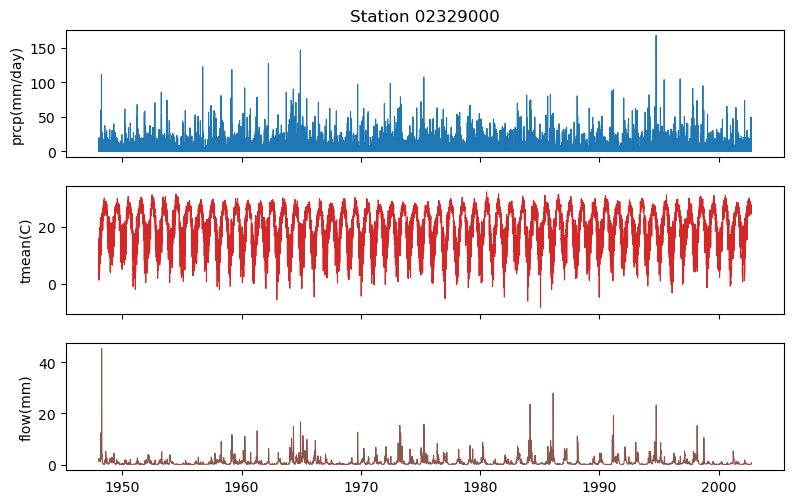

In [5]:
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(8, 5))
fig.tight_layout()

ax1.plot(hydrodata['prcp'],  'tab:blue', lw=0.8)
ax2.plot(hydrodata['tmean'], 'tab:red',  lw=0.8)
ax3.plot(hydrodata['flow'],  'tab:brown', lw=0.8)

ax1.set_title(f"Station {STATION_ID}")
ax1.set_ylabel("prcp(mm/day)")
ax2.set_ylabel("tmean(C)")
ax3.set_ylabel("flow(mm)")

plt.show()

### Gerenate data pairs (x and y) for the given `WRAP_LENGTH`

In [6]:
if os.path.exists(data_path):
    with open(data_path, 'rb') as f:
        data_x_dict, data_y_dict = pickle.load(f)
else:
    data_x_dict, data_y_dict = xdata.get_wrapped_data(dataset=hydrodata,  wrap_length=WRAP_LENGTH)
    with open(data_path, 'wb') as f:
        pickle.dump([data_x_dict, data_y_dict], f)

Preparing data with wrap length = 180:   0%|          | 0/19997 [00:00<?, ?it/s]

### Split data samples for training and testing

In [7]:
split_results = xdata.split_train_test(dataset=hydrodata, 
                                       data_x_dict=data_x_dict, 
                                       data_y_dict=data_y_dict, 
                                       frac=TRAIN_FRAC, 
                                       random_state=RANDOM_SEED, 
                                       scale=True)

train_dates, test_dates, x_train, y_train, x_test, y_test, scale_params = split_results

print(f'The shape of x_train, y_train after wrapping by {WRAP_LENGTH} days are {x_train.shape}, {y_train.shape}')
print(f'The shape of x_test, y_test after wrapping by {WRAP_LENGTH} days are   {x_test.shape}, {y_test.shape}')

The shape of x_train, y_train after wrapping by 180 days are (13872, 180, 2), (13872, 1)
The shape of x_test, y_test after wrapping by 180 days are   (5945, 180, 2), (5945, 1)


## 2. Model building and evaluation

In [8]:
inputs = layers.Input(x_train.shape[1:], name='input')
lstm   = layers.LSTM(units=16, name='lstm', 
                     kernel_regularizer=regularizers.l2(0.001), 
                     recurrent_regularizer=regularizers.l2(0.001))(inputs)
output = layers.Dense(units=1, name='dense', activation='linear', use_bias=False, 
                      kernel_regularizer=regularizers.l2(0.001))(lstm)

model  = models.Model(inputs, output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 180, 2)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                1216      
_________________________________________________________________
dense (Dense)                (None, 1)                 16        
Total params: 1,232
Trainable params: 1,232
Non-trainable params: 0
_________________________________________________________________


In [9]:
es     = callbacks.EarlyStopping(monitor='val_R2', mode='max', verbose=1, patience=30, 
                                 min_delta=0.01, restore_best_weights=True)
reduce = callbacks.ReduceLROnPlateau(monitor='val_R2', factor=0.5, patience=15, verbose=1, 
                                     mode='max', min_delta=0.01, cooldown=0, min_lr=LEARNING_RATE / 100)
tnan   = callbacks.TerminateOnNaN()

model.compile(loss='mse', metrics=[xutils.R2], optimizer=optimizers.Adam(lr=LEARNING_RATE))
model.fit(x_train, y_train, epochs=EPOCH_NUMBER, batch_size=1024, validation_split=0.3, callbacks=[es, reduce, tnan])
model.save(model_path)

Train on 9710 samples, validate on 4162 samples
Epoch 1/100
9710/9710 [==============================] - 2s 195us/sample - loss: 0.8389 - R2: 0.2352 - val_loss: 0.7739 - val_R2: 0.2105
Epoch 2/100
9710/9710 [==============================] - 1s 154us/sample - loss: 0.8259 - R2: 0.2154 - val_loss: 0.7162 - val_R2: 0.3091
Epoch 3/100
9710/9710 [==============================] - 2s 156us/sample - loss: 0.6842 - R2: 0.3643 - val_loss: 0.5129 - val_R2: 0.5305
Epoch 4/100
9710/9710 [==============================] - 2s 161us/sample - loss: 0.5389 - R2: 0.5156 - val_loss: 0.4153 - val_R2: 0.6347
Epoch 5/100
9710/9710 [==============================] - 2s 164us/sample - loss: 0.4438 - R2: 0.6093 - val_loss: 0.3079 - val_R2: 0.7395
Epoch 6/100
9710/9710 [==============================] - 2s 161us/sample - loss: 0.4465 - R2: 0.6021 - val_loss: 0.4132 - val_R2: 0.5772
Epoch 7/100
9710/9710 [==============================] - 2s 160us/sample - loss: 0.4419 - R2: 0.6089 - val_loss: 0.3116 - val_R2: 

Epoch 58/100
9710/9710 [==============================] - 2s 169us/sample - loss: 0.1456 - R2: 0.9043 - val_loss: 0.1541 - val_R2: 0.8940
Epoch 59/100
9710/9710 [==============================] - 2s 163us/sample - loss: 0.1459 - R2: 0.9037 - val_loss: 0.1566 - val_R2: 0.8852
Epoch 60/100
9710/9710 [==============================] - 2s 161us/sample - loss: 0.1426 - R2: 0.9058 - val_loss: 0.1504 - val_R2: 0.8959
Epoch 61/100
9710/9710 [==============================] - 2s 163us/sample - loss: 0.1416 - R2: 0.9089 - val_loss: 0.1520 - val_R2: 0.9061
Epoch 62/100
9710/9710 [==============================] - 2s 162us/sample - loss: 0.1396 - R2: 0.9112 - val_loss: 0.1568 - val_R2: 0.8975
Epoch 63/100
9710/9710 [==============================] - 2s 168us/sample - loss: 0.1419 - R2: 0.9063 - val_loss: 0.1492 - val_R2: 0.8939
Epoch 64/100
9710/9710 [==============================] - 2s 163us/sample - loss: 0.1416 - R2: 0.9082 - val_loss: 0.1610 - val_R2: 0.8853
Epoch 65/100
9710/9710 [==========

In [10]:
eval_model = models.load_model(model_path, custom_objects={'R2': xutils.R2})
pred_train = eval_model.predict(x_train, batch_size=1024)
pred_test  = eval_model.predict(x_test, batch_size=1024)

print(f"NSE for the training data: {xutils.cal_nse(y_train, pred_train):.3f}")
print(f"NSE for the testing data:  {xutils.cal_nse(y_test, pred_test):.3f}")

NSE for the training data: 0.906
NSE for the testing data:  0.901


In [11]:
hydrodata.loc[train_dates, ['flow_pred']] = pred_train * scale_params['train_y_std'] + scale_params['train_y_mean']
hydrodata.loc[test_dates,  ['flow_pred']] = pred_test  * scale_params['train_y_std'] + scale_params['train_y_mean']

## 3. Identify important flood peaks by peaks-over-threshold method

Identify flood peaks based on scipy `find_peaks` function.

For more arguments, please see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

In [12]:
peak_dates = xutils.identify_peaks(Q = hydrodata['flow'].loc[list(data_y_dict.keys())], 
                                   distance=14)

A total of 92 flood peaks are identified.


### A glimpse of the identified flood peaks

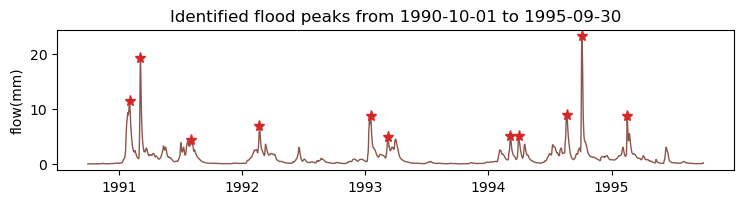

In [13]:
xplot.plot_peaks(hydrodata, peak_dates, plot_range=['1990-10-01', '1995-09-30'])

# 4. Interpret LSTM models by expected gradients

***For getting the feature importance scores for all the flood peaks:***

In [14]:
eval_x_dict  = dict((peak_date, data_x_dict[peak_date]) for peak_date in peak_dates if peak_date in data_x_dict)

***For getting the feature importance scores for a specific flood peak:***

In [15]:
peak_date='1991-02-02'
eval_x_dict  = dict((peak_date, data_x_dict[peak_date]) for peak_date in [pd.to_datetime(peak_date)] if peak_date in data_x_dict)

In [16]:
peak_eg_dict, peak_eg_var_dict = xinterpret.interpret_eg(model=eval_model, 
                                                         background=x_train, 
                                                         x_dict=eval_x_dict, 
                                                         scale_params=scale_params, 
                                                         path=eg_path, 
                                                         overwrite=True)

Create a GradientExplainer and calculate EG values. Please be patient, it would take some time...


  0%|          | 0/1 [00:00<?, ?it/s]

Done! The file is saved to results/eg/02329000_100_eg.pickle


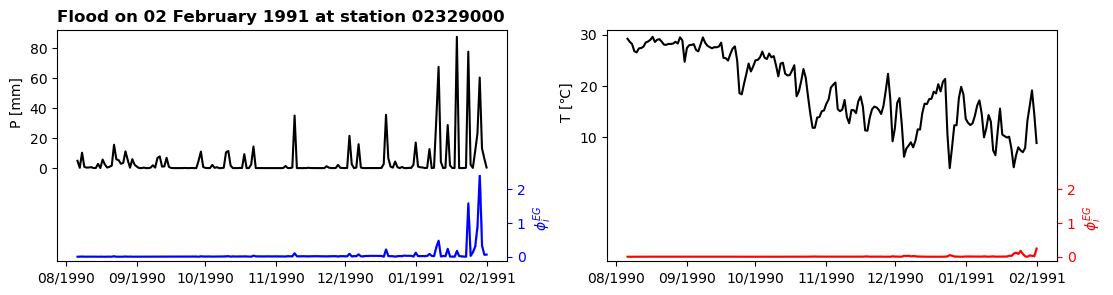

In [17]:
xplot.plot_eg_individual(dataset=hydrodata, 
                         peak_eg_dict=peak_eg_dict, 
                         peak_eg_var_dict=peak_eg_var_dict, 
                         peak_date=peak_date, 
                         title_suffix=f'at station {STATION_ID}')

## 5. Interpret LSTM models by additive decomposition

In [18]:
decomp_dict = xinterpret.interpret_decomp(eval_model).get_internals(eval_x_dict, scale_params=scale_params)

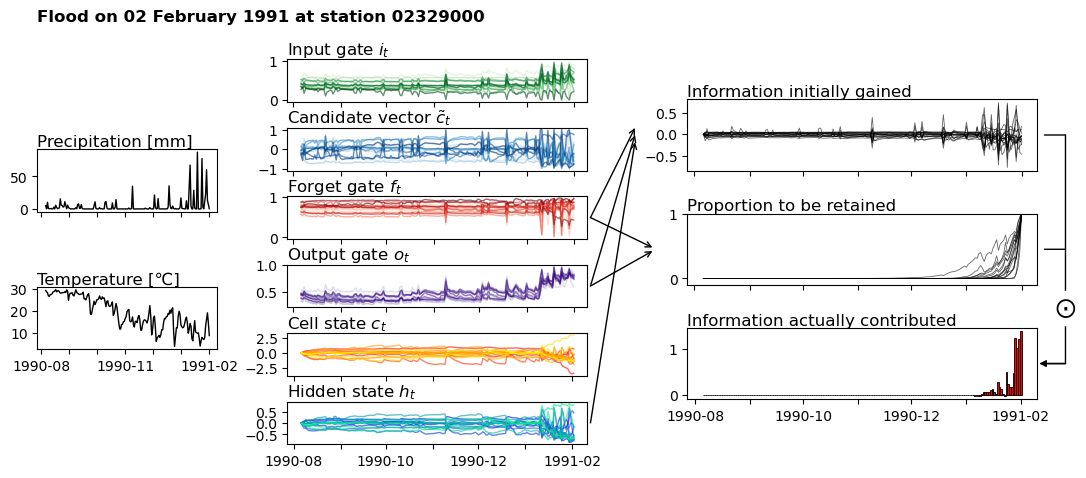

In [19]:
xplot.plot_decomp(dataset=hydrodata, 
                  decomp_dict=decomp_dict, 
                  peak_date=peak_date, 
                  title_suffix=f'at station {STATION_ID}')